# Analyze A/B Test project

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)


<a id='intro'></a>
### Introduction

For this project, I will be working to understand the results of an A/B test run by an e-commerce website. My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps lengthen the duration of the experiment to get more meaningful results to make the best decision.

Also not neglecting the ability to provide more data to support the analysis with more variables that can help decision makers get more meaningful results for their decision.

In order to follow the path of the analysis, several questions will be proposed throughout the analysis to keep the intuition on the approach followed in A/B testing

<a id='probability'></a>
### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
len(df.query('converted == 1'))/df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "treatment" and landing_page == "old_page"').count()[0]

1965

In [7]:
df[((df['group'] == 'treatment') != (df['landing_page'] == 'new_page'))].count()[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

Store your new dataframe in **df2**.

In [9]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) & 
         ((df['group'] == 'control') == (df['landing_page'] == 'old_page'))]

df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Doing some data cleaning.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.user_id.drop_duplicates(inplace=True)

In [14]:
#check for dublicated values, if they excist
sum(df2.user_id.duplicated())

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
con_control = df2.query('group == "control"')['converted'].mean()
con_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
con_treat = df2.query('group == "treatment"')['converted'].mean()
con_treat

0.11880724790277405

d. What is the probability that an individual received the new page?

In [18]:
df2[(df['landing_page'] == 'new_page')]['user_id'].count()/df2.shape[0]

0.5000636646764286

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Based on the results of points a through d, there is not enough evidence that the new page increases the number of conversions. Because there are just 50% of the users who received the new page as well as the conversion rate for the treatment group is just around 12%. We need to do more testing to know the impact of the new page on the conversion rate of the website.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider I need to make the decision just based on all the data provided.  I assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should null and alternative hypotheses be?  I state hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}:$** $p_{old}$ >= $p_{new}$

**$H_{1}:$** $p_{new}$ > $p_{old}$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

I perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
conv_p_new = df2.converted.mean()
round(conv_p_new, 4)

0.1196

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
conv_p_old = df2.converted.mean()
round(conv_p_old, 4)

0.1196

c. What is $n_{new}$?

In [21]:
n_new = len(df2.query('landing_page == "new_page"'))
n_new

145311

d. What is $n_{old}$?

In [22]:
n_old = len(df2.query('landing_page == "old_page"'))
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[1-conv_p_new, conv_p_new])
new_page_converted

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[1-conv_p_old, conv_p_old])
old_page_converted

array([1, 0, 1, ..., 1, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
np.mean(new_page_converted).round(2) - np.mean(old_page_converted).round(2)

0.0

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
new_page_converted = np.random.binomial(n_new,conv_p_new,10000)/n_new
old_page_converted = np.random.binomial(n_old,conv_p_old,10000)/n_old
p_diffs = new_page_converted - old_page_converted
p_diffs

array([ 0.00173821,  0.00117408,  0.00031363, ...,  0.00065765,
       -0.00076684, -0.00073928])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

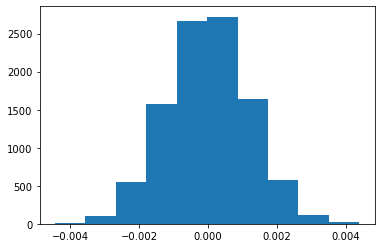

In [27]:
#Plotting of simulation resultats
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
diff_obs = con_treat - con_control
diff_obs

-0.0015790565976871451

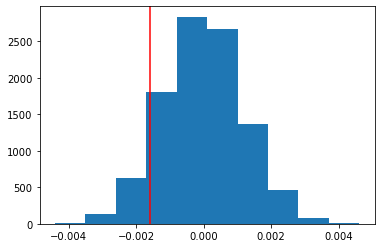

In [29]:
null_vals = np.random.normal(0, np.std(p_diffs), np.array(p_diffs).size)
#Plotting null values distribution
plt.hist(null_vals)
#Plotting vertical line for observed statistic
plt.axvline(x=diff_obs,color ='red');

In [30]:
#Calculing the P_value
(p_diffs > diff_obs).mean()

0.9081

k. Refering to **j.** question.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**In a statistical test, the p-value is the probability for a given our statistic under the null hypothesis of obtaining the same or an even more extreme value than that observed.**

**In our case the p-value is greater than the type I error threshold of 5%, which means that we fail to reject the H0 hypothesis, so it shows that the new page does not generate enough traffic and purchase fulfillment for this e-commerce website.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [31]:
import statsmodels.api as sm
#counting the number of converting purchase for each page
convert_old = df2.query('landing_page == "old_page" and converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').count()[0]
#counting the number of each page
n_old = df2.query('landing_page =="old_page"').count()[0]
n_new = df2.query('landing_page =="new_page"').count()[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145311)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [32]:
# We use smaller for alternative parameter because the alternative hypothesis is Pnew > Pold
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3116075339133115, 0.905173705140591)

n. What do the z-score and p-value I computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**In the z-table, value of 1.13 of our the z-score is 0.9049, which is less than 95%, our confidence interval and the same p_value get in this test too, mean we  fail to reject null hypothesis. Both of this results found in parts j and k. There is no significant evidence that the new page will contribute to more conversion of purchase in this e-commerce platform.**

NB: [z table](https://www.ztable.net/)

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**The type of regression should be performing in this case is: Logistic Regression, because in our case we have a categorical variables**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, I need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept'] = 1
#create dummy variables for users receiving new page
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

c. I use **statsmodels** to import my regression model.  Instantiate the model, and fit the model using the two columns I created in part **b.** to predict whether or not an individual converts.

In [34]:
# Instantiating the model
logm = sm.Logit(df2.converted, df2[['intercept', 'ab_page']])

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
# Fitting the model
result = logm.fit()
# Displaying summary results
result.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Thu, 28 May 2020   Pseudo R-squ.:               8.085e-06
Time:                        22:24:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value I found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**1) The p_value associated with ab_page is: 0.190.**

**2) In this model the null hypothese is that group those recieves treatment page are the same as those recieves control page, the alternative hypothese is they are any difference between 2 groups.**

**3) In Part II we preform a one-sided test on this question we perform a two-sided test.**

f. Now, I considering other things that might influence whether or not an individual converts.  Why it is a good idea to consider other factors to add into your regression model?  Are there any disadvantages to adding additional terms into regression model?

**We can add other variables to increase the predictability of the model, these variables can have more influence on the conversion, such as timestamps, which informs us how much time is spent on the site and over which day period the conversion increases. But adding variables that depend on each other can lead to multicolinearity, also adding more variables can make the interpretation of the model more complex.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. I will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 

Does it appear that country had an impact on conversion?

In [36]:
countries_df = pd.read_csv('countries.csv')
#Joining the countries dataset columns to ab_dataset
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1


In [37]:
#Creating dummy variables for country column
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1


In [38]:
#Calculing the users receiving new page from 3 countries 
df_new['us_page'] = df_new.ab_page*df_new.US
df_new['uk_page'] = df_new.ab_page*df_new.UK
df_new['ca_page'] = df_new.ab_page*df_new.CA
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,us_page,uk_page,ca_page
user_id,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1,1,0,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1,1,0,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1,0,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1,1,0,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1,1,0,0


h. Though I have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [39]:
#Chosing the US users as baseline for our interpretation 
logm2 = sm.Logit(df_new.converted, df_new[['intercept', 'CA', 'UK']])
result2 = logm2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366115
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            2
Date:                Thu, 28 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        22:24:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1983
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.315      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [40]:
#Exponentiation of parameters of our model to can interpret them 
np.exp(result2.params)

intercept    0.135778
CA           0.960024
UK           1.009971
dtype: float64

In [41]:
print('intercept_recep =', 1/0.135778)
print('CA_recep =', 1/0.960024)

intercept_recep = 7.3649633961319205
CA_recep = 1.0416406256510253


**For this model fitting we can notice that none of these variables is obviously significant for predicting the conversion (greater than 0.05), except the intercept which has a p-value close to 0.**

**For each user coming from UK there is an increase of 1.01 of converting unit, for each user coming from CA there is an derease of 1.041 unit for every unit converted, keeping the other variables constant.**

**We will add the new page effect for visitors coming from CA and UK, to try to find more meaning and interpretation of the results.**


In [42]:
#Chosing the us_page as baseline for our interpretation 
# Instantiating the model
logm_more = sm.Logit(df_new.converted, df_new[['intercept', 'CA', 'UK', 'ca_page', 'uk_page']])
# Fitting the model
result_more = logm_more.fit()
# Displaying summary results
result_more.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            4
Date:                Thu, 28 May 2020   Pseudo R-squ.:               2.417e-05
Time:                        22:24:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.2729
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.315      0.000      -2.010      -1.983
CA            -0.0073      0.037     -0.196      0.844      -0.080       0.065
UK             0.0045      0.018      0.258      0.797      -0.030       0.039
ca_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
uk_page        0.0108      0.023      0.475      0.635      -0.034       0.056
==============================================================================
"""

In [43]:
np.exp(result_more.params)

intercept    0.135778
CA           0.992755
UK           1.004523
ca_page      0.934776
uk_page      1.010893
dtype: float64

In [44]:
#reciprocal values for intercept parameter and ab_page parameter 
print('intercept_recep =', 1/0.137178)
print('CA_recep =', 1/0.982625)
print('ca_page_recp =', 1/0.994272)

intercept_recep = 7.289798655761128
CA_recep = 1.017682228724081
ca_page_recp = 1.005760999002285


**Even with the addition of other variables, the intercept remains the most statistically significant variable in this model.**

**For each user coming from UK there is an increase of converted by 1.005 unit, for each user coming from CA there is an derease of 1.017 unit for every unit converted keeping the other variables constant.**

**For each user coming from UK who received the new one there is an increase of 1.01 unit of conversion respectively, for each user coming from CA who received the new one there is an derease of 1.006 unit for every unit converted keeping the other variables constant.**

**All these interpretations show that the impact of the variables on the predictability of the model is almost unremarkable at all.**

**We try out to make some model diagntostics** 

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

In [46]:
X = df_new[['CA', 'UK', 'ca_page', 'uk_page']]   #Predictor variables
y = df_new['converted']    # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
log_model = LogisticRegression()
results = log_model.fit(X_train,y_train) # fit the train data
preds = results.predict(X_test)
#Calculing many scores to diagnostic the model 
print('Precision score is:', precision_score(y_test, preds))
print('Recall score is:', recall_score(y_test, preds))
print( 'Confusion matrix is:\n',confusion_matrix(y_test, preds))
print( 'Accuracy score is:',accuracy_score(y_test, preds).round(4))

Precision score is: 0.0
Recall score is: 0.0
Confusion matrix is:
 [[51180     0]
 [ 6937     0]]
Accuracy score is: 0.8806


In [47]:
from sklearn.model_selection import cross_val_score
#Calculating the cross validation score 
scores = cross_val_score(results, X_train, y_train, cv=10)
print( 'Cross validation scores are:',scores.round(4))

Cross validation scores are: [0.8804 0.8804 0.8803 0.8803 0.8803 0.8803 0.8803 0.8803 0.8804 0.8804]


In [48]:
#Calculing the min and max also mean of cross validation score 
scores = pd.Series(scores.round(4))
scores.min(), scores.mean(), scores.max()

(0.8803, 0.88034, 0.8804)

**The prediction accuracy of this model is quite high, almost 88%. We obtained this score using accuracy score and cross validation score, which both show close values to 88%.**

**We will add the variable timestamp to try to detect the effect of time on the predictability of the model and the statistical significance of the variables.**

In [49]:
#Converting the timestamp column to from string to date time type 
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])
#Extracting the hours data and weekday data
df_new['hours'] = df_new['timestamp'].dt.hour
df_new['days'] = df_new['timestamp'].dt.weekday

In [50]:
#Dividing the hours and days values to categories 
df_new['time_day'] = df_new['hours'].apply(lambda x : { x <12:'Morning', 12<=x<18:'Afternoon'}.get(True, 'Night'))
df_new['week_day'] = df_new['days'].apply(lambda x : { x <6:'weekday'}.get(True, 'weekend'))
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,us_page,uk_page,ca_page,hours,days,time_day,week_day
user_id,,,,,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1,1,0,0,6,3,Morning,weekday
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1,1,0,0,3,0,Morning,weekday
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1,0,0,0,19,3,Night,weekday
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1,1,0,0,10,3,Morning,weekday
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1,1,0,0,20,2,Night,weekday


In [51]:
#Creatin dummy variables for tim_day variable and week_day variable
df_new[['Afternoon', 'Morning', 'Night']] = pd.get_dummies(df_new['time_day'])
df_new[['weekday', 'weekend']] = pd.get_dummies(df_new['week_day'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,...,ca_page,hours,days,time_day,week_day,Afternoon,Morning,Night,weekday,weekend
user_id,,,,,,,,,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,0,1,...,0,6,3,Morning,weekday,0,1,0,1,0
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,0,1,...,0,3,0,Morning,weekday,0,1,0,1,0
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,0,0,1,...,0,19,3,Night,weekday,0,0,1,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,0,1,...,0,10,3,Morning,weekday,0,1,0,1,0
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,0,1,...,0,20,2,Night,weekday,0,0,1,1,0


In [52]:
#Chosing the afternoon and weekend variables as baseline for our interpretation 
logm_time = sm.Logit(df_new.converted, df_new[['intercept', 'ab_page', 'US', 'UK', 'us_page', 'uk_page', 
                                               'Morning', 'Night', 'weekday']])
result_time = logm_time.fit()
result_time.summary()

Optimization terminated successfully.
         Current function value: 0.366099
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290576
Method:                           MLE   Df Model:                            8
Date:                Thu, 28 May 2020   Pseudo R-squ.:               5.786e-05
Time:                        22:25:15   Log-Likelihood:            -1.0638e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1378
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0059      0.040    -49.650      0.000      -2.085      -1.927
ab_page       -0.0672      0.052     -1.292      0.196      -0.169       0.035
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK             0.0118      0.040      0.297      0.766      -0.066       0.090
us_page        0.0466      0.054      0.866      0.386      -0.059       0.152
uk_page        0.0781      0.057      1.374      0.169      -0.033       0.189
Morning       -0.0207      0.014     -1.483      0.138      -0.048       0.007
Night          0.0055      0.016      0.341      0.733      -0.026       0.037
weekday        0.0126      0.017      0.756      0.450      -0.020       0.045
==============================================================================
"""

In [53]:
X = df_new[['ab_page', 'US', 'UK', 'us_page', 'uk_page', 'Morning', 'Night', 'weekday']]   #Predictor variables
y = df_new['converted']    # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)
log_time = LogisticRegression() #fitting the model 
rslt = log_time.fit(X_train,y_train) # fit the train data
preds = rslt.predict(X_test)
#Calculing many scores to diagnostic the model 
print('Precision score is:', precision_score(y_test, preds))
print('Recall score is:', recall_score(y_test, preds))
print( 'Confusion matrix is:\n',confusion_matrix(y_test, preds))
print( 'Accuracy score is:',accuracy_score(y_test, preds).round(4))

Precision score is: 0.0
Recall score is: 0.0
Confusion matrix is:
 [[51180     0]
 [ 6937     0]]
Accuracy score is: 0.8806


In [54]:
score_time = cross_val_score(rslt, X_train, y_train, cv=10)
print( 'Cross validation scores are:',score_time.round(4))

Cross validation scores are: [0.8804 0.8804 0.8803 0.8803 0.8803 0.8803 0.8803 0.8803 0.8804 0.8804]


In [55]:
score_time = pd.Series(score_time.round(4))
score_time.min(), score_time.mean(), score_time.max()

(0.8803, 0.88034, 0.8804)

**Even we added the effect of time on the model we found no remarkable effect on the model, so that the p-value of the variables remains close to the old values before adding the time variables.**

**Also the accuracy score stay the same even after adding more variables**

<a id='conclusion'></a>
### Conclusion
**In this case study, we can see that all the variables used and the data collected does not help the company to anticipate the use of the new web page for its e-commerce site, because the convertibility rate did not significantly change the users' decision to convert visits to purchases. Also, even with the addition of the variable time and origin of visits, the decision remains difficult to make even if it is not found. It is preferable to look for other variables that can help the decision to adopt the new page or not, for example, study the click areas in the old page to detect the most consulted information in the page to highlight them in the new page and enlighten them.** 